## Content-Based Recommendation System

In [46]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
jobs_df = pd.read_csv("Combined_Jobs_Final.csv")
jobs_df.columns

Index(['Job.ID', 'Provider', 'Status', 'Slug', 'Title', 'Position', 'Company',
       'City', 'State.Name', 'State.Code', 'Address', 'Latitude', 'Longitude',
       'Industry', 'Job.Description', 'Requirements', 'Salary',
       'Listing.Start', 'Listing.End', 'Employment.Type', 'Education.Required',
       'Created.At', 'Updated.At'],
      dtype='object')

In [3]:
jobs_df.shape

(84090, 23)

In [4]:
jobs_df.isna().sum()

Job.ID                    0
Provider                  0
Status                    0
Slug                      0
Title                     0
Position                  0
Company                2271
City                    135
State.Name              171
State.Code              171
Address               84054
Latitude                  0
Longitude                 0
Industry              83823
Job.Description          56
Requirements          84090
Salary                83861
Listing.Start           683
Listing.End             167
Employment.Type          10
Education.Required      267
Created.At                0
Updated.At                0
dtype: int64

In [5]:
jobs_df_subset = jobs_df[['Job.ID', 'Position', 'Company','City', 'State.Name','Job.Description', 
                      'Employment.Type','Education.Required', 'Latitude','Longitude']]
jobs_df_subset.columns = jobs_df_subset.columns.str.replace(r".", "_")
jobs_df_subset.columns = jobs_df_subset.columns.str.lower()

In [6]:
import folium
mapit = folium.Map(location=[36.650952, -103.973350], zoom_start=4 )
for coord in zip(jobs_df_subset.latitude[0:10000], jobs_df_subset.longitude[0:10000]): #plot of first 10K jobs
    folium.Circle( location=[coord[0], coord[1]],radius=20, fill=False).add_to(mapit)
mapit
# mapit.save( 'map.html')

In [7]:
import re
import string
from nltk.corpus import stopwords
stop = set(stopwords.words("english"))

#cleaning function to remove unnecessary empty lines and apply stopwords, lemmatizing and stemming
def data_cleaning(only_text, lemmatize = False):
    only_text = only_text.str.replace('[^a-zA-Z \n\.]'," ") #remove unnecesary characters
    only_text = only_text.str.lower() #lowercase
    only_text = only_text.apply(lambda x : x.replace('\n','')) #removing new line
    only_text = only_text.apply(lambda x : x.replace('\t','')) # removing new tab
    only_text = only_text.apply(lambda x: " ".join(word for word in x.split() if word not in string.ascii_letters))
    only_text = only_text.apply(lambda x : ' '.join([word for word in x.split() if word not in (stop)])) #remove stop words
    if lemmatize:
        only_text = only_text.apply(lambda x : " ".join(lemmatize_sentence(x))) #brininging words to root using lemmatization
    return only_text

In [8]:
jobs_df_subset['position_cleaned'] = data_cleaning(jobs_df_subset.position)

C:\Users\mohad\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");
    

def word_cloud(df,column_name):
    wordcloud = WordCloud(width = 1500, height = 800, background_color='salmon', colormap='Pastel1').generate(str(list(df[column_name])))
    plot_cloud(wordcloud)


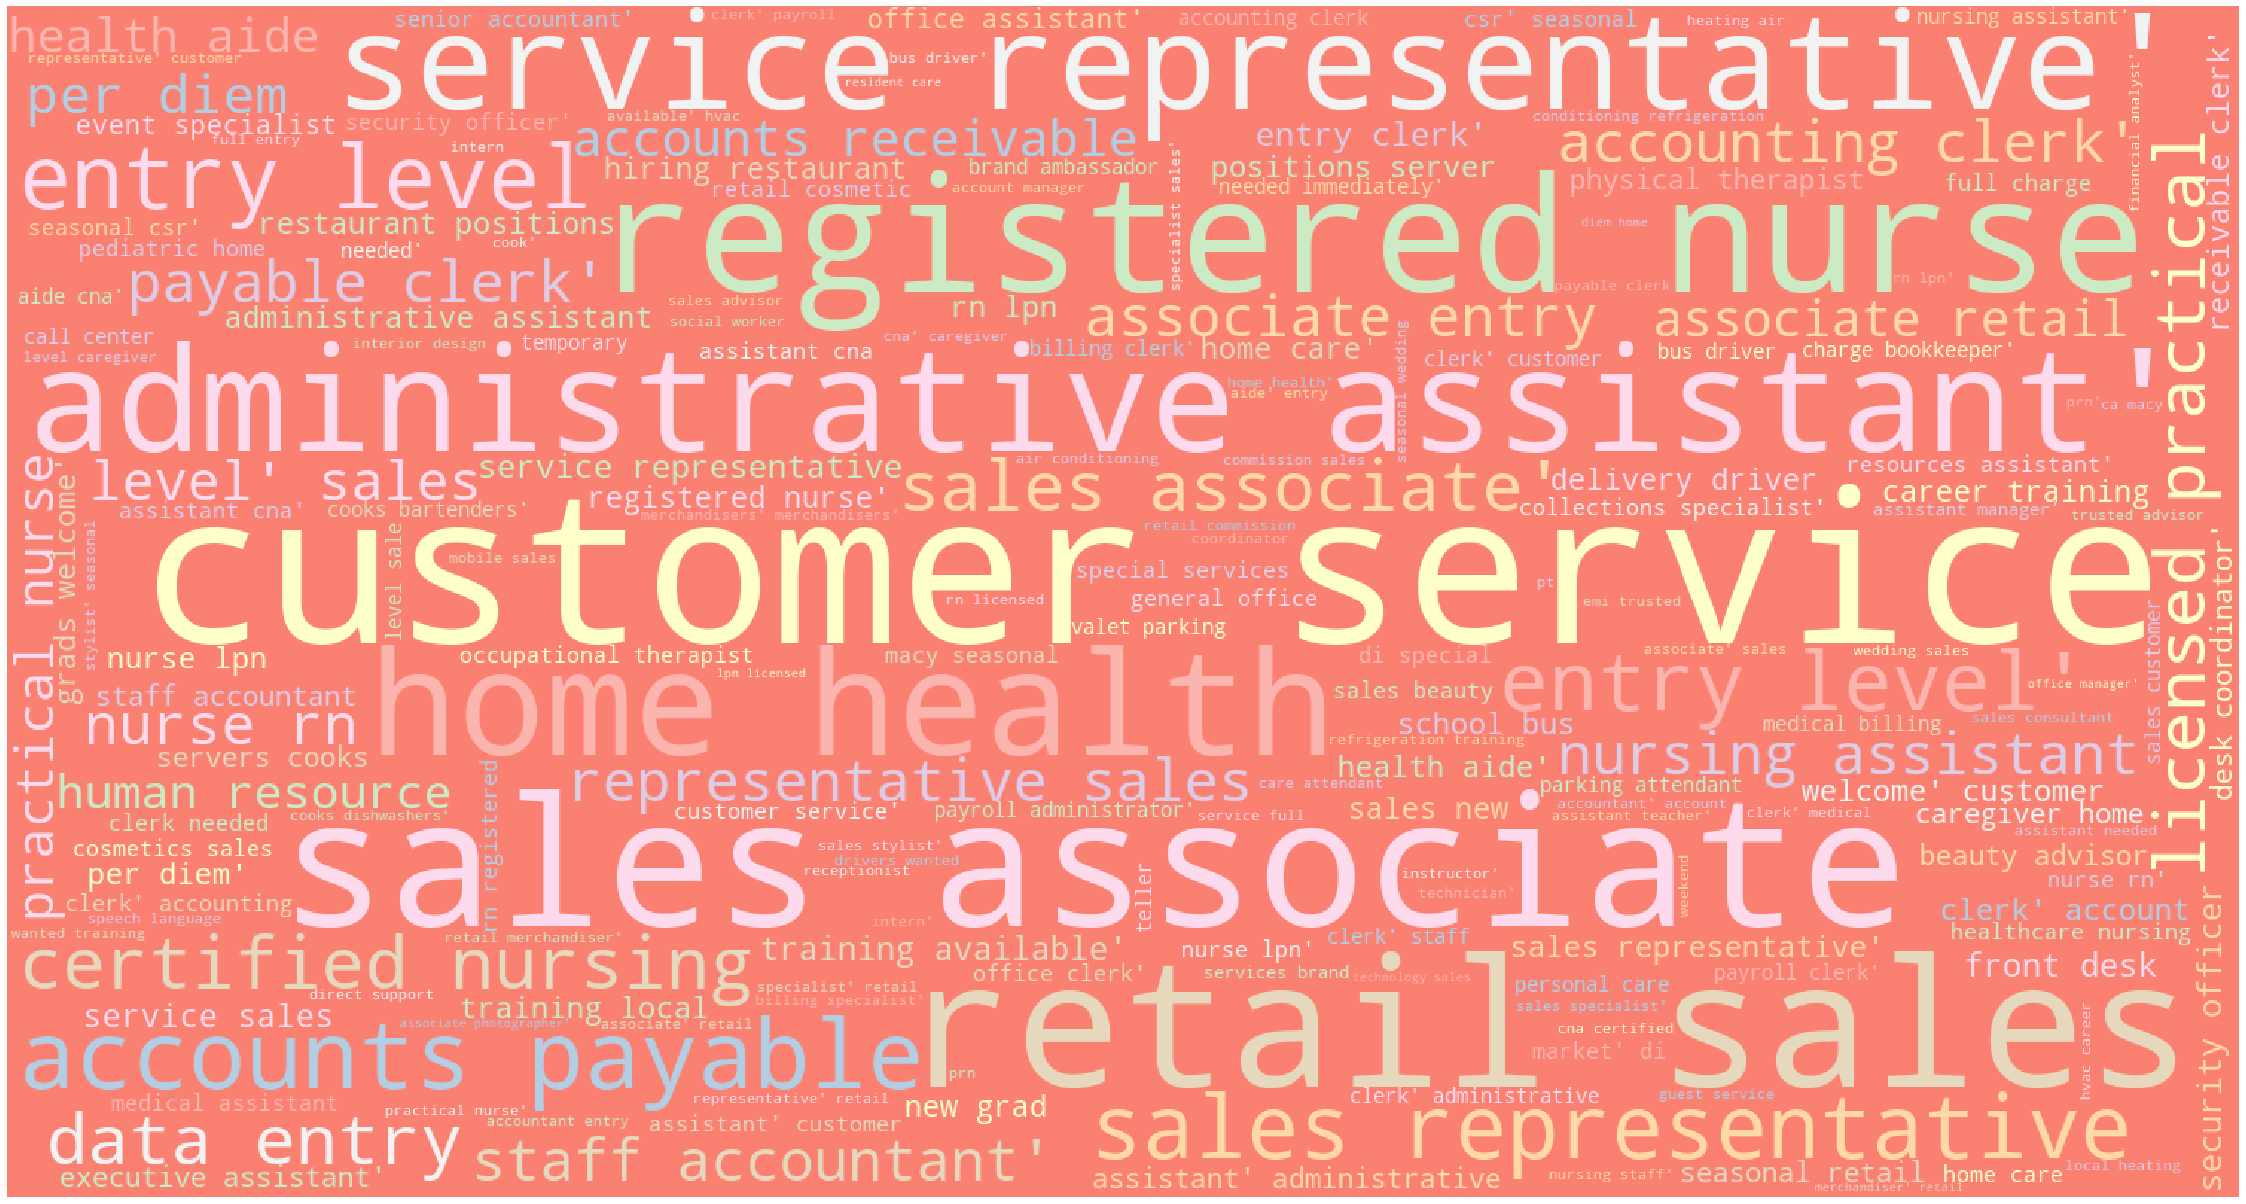

In [14]:
jobs_df_subset['position_cleaned'] = jobs_df_subset.position_cleaned.str.replace('part|time',' ')
word_cloud(jobs_df_subset, 'position_cleaned') 

#### Company

In [28]:
jobs_df_subset['company_cleaned']  = jobs_df_subset.company.fillna("")
jobs_df_subset['company_cleaned'] = data_cleaning(jobs_df_subset.company_cleaned)

#### City

In [15]:
jobs_df_subset['city_cleaned'] = jobs_df_subset.city.fillna("")
jobs_df_subset['city_cleaned'] = data_cleaning(jobs_df_subset.city_cleaned)

In [16]:
import seaborn as sns
def freq_fn(one_column,xlabel_input='number of meetings', title_input='title', top_10=True):
    df_freq = pd.DataFrame(one_column.value_counts())
    df_freq.reset_index(inplace=True)
    df_freq.columns = ['response','freq']
    
    if top_10:
        df_freq = df_freq.head(10)

    fig,ax = plt.subplots()
    #these are pre-definations for plot fig is defined to change 

    fig.set_size_inches(12,5)
    #this is the dimensions of the plot

    sns.barplot(data=df_freq,x="response",y="freq",ax=ax)
    #to create a bar type of plot where x axis is variable type and y axis is count and dataframe is dataTypeDF

    ax.set(xlabel=xlabel_input, ylabel='Count',title=title_input)
    #create the names for axis

    #adding the text labels printing the frequency on top of each bar
    for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2, p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
    plt.show()
    

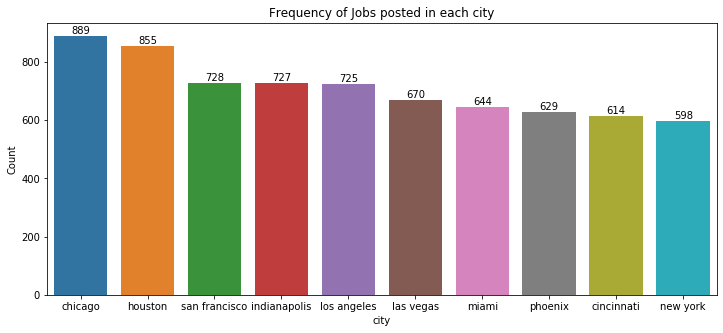

In [17]:
freq_fn(jobs_df_subset.city_cleaned,title_input='Frequency of Jobs posted in each city', xlabel_input='city')

#### State

In [18]:
jobs_df_subset['state_cleaned'] = jobs_df_subset.state_name.fillna("")
jobs_df_subset['state_cleaned'] = data_cleaning(jobs_df_subset.state_cleaned)

#### job_description

In [19]:
jobs_df_subset['job_description_cleaned'] = jobs_df_subset.job_description.fillna("")
jobs_df_subset['job_description_cleaned'] = data_cleaning(jobs_df_subset.job_description_cleaned, lemmatize=False)

In [20]:
count = jobs_df_subset['job_description'].fillna("").str.split().apply(len)
count.mean() #on an average there are 200 words which is too much to build a recommendation engine

212.69810916874778

In [21]:
count = jobs_df_subset['job_description_cleaned'].str.split().apply(len)
count.mean() #we have reduced it to 144 words

144.09627779759782

#### Employment type

In [22]:
jobs_df_subset['employment_type_cleaned'] = jobs_df_subset.employment_type.fillna(" ")
jobs_df_subset['employment_type_cleaned'] = jobs_df_subset.employment_type_cleaned.str.lower()
jobs_df_subset['employment_type_cleaned'] = jobs_df_subset.employment_type_cleaned.str.replace('-|/| ','')

In [23]:
jobs_df_subset.employment_type_cleaned.value_counts()

parttime             33228
seasonaltemp         27609
fulltimeparttime     17626
perdiem               4644
intern                 921
fulltime                37
contract                14
                        10
temporaryseasonal        1
Name: employment_type_cleaned, dtype: int64

##### Education 

In [24]:
jobs_df_subset['education_required_cleaned'] = jobs_df_subset.education_required.fillna(" ")
jobs_df_subset['education_required_cleaned'] = jobs_df_subset.education_required_cleaned.str.lower()
jobs_df_subset['education_required_cleaned'] = jobs_df_subset.education_required_cleaned.str.replace(" |'","")

In [25]:
jobs_df_subset.education_required_cleaned.value_counts()

notspecified         62182
highschooldiploma    14250
associatedegree       3483
bachelorsdegree       2849
mastersdegree         1059
                       267
Name: education_required_cleaned, dtype: int64

#### Modeling

In [29]:
model_data = jobs_df_subset[['job_id','position_cleaned','company_cleaned','city_cleaned','state_cleaned',
                           'job_description_cleaned','employment_type_cleaned', 'education_required_cleaned']]

In [30]:
model_data['combined'] = model_data[model_data.columns[1:]].apply(lambda x: ' '.join(x.dropna().astype(str)),axis=1)

In [55]:
#initializing tfidf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

tfidf_vectorizer = TfidfVectorizer(min_df=.001)

tfidf_jobid = tfidf_vectorizer.fit_transform((model_data['combined'])) #fitting and transforming the vector
tfidf_jobid

<84090x6814 sparse matrix of type '<class 'numpy.float64'>'
	with 8756564 stored elements in Compressed Sparse Row format>

In [56]:
#creating a dense matrix
tfidf_jobid_dense = tfidf_jobid.todense()

# User Corpus

#### job_view

In [31]:
#taking the datasets job view, position of interest, experience of the applicant into consideration for creating a query
job_view = pd.read_csv("Job_Views.csv")
job_view.head(3)

Applicant.ID  Job.ID                                              Title  \
0         10000   73666              Cashiers & Valets Needed! @ WallyPark   
1         10000   96655  Macy's Seasonal Retail Fragrance Cashier  - Ga...   
2         10001   84141  Part Time Showroom Sales / Cashier @ Grizzly I...   

                                            Position                  Company  \
0                          Cashiers & Valets Needed!                WallyPark   
1  Macy's Seasonal Retail Fragrance Cashier  - Ga...                   Macy's   
2                 Part Time Showroom Sales / Cashier  Grizzly Industrial Inc.   

          City  State.Name State.Code Industry               View.Start  \
0       Newark  New Jersey         NJ      NaN  2014-12-12 20:12:35 UTC   
1  Garden City    New York         NY      NaN  2014-12-12 20:08:50 UTC   
2   Bellingham  Washington         WA      NaN  2014-12-12 20:12:32 UTC   

                  View.End  View.Duration               Created.At  \
0  2014-12-12 20:31:24 UTC         1129.0  2014-12-12 20:12:35 UTC   
1  2014-12-12 20:10:15 UTC           84.0  2014-12-12 20:08:50 UTC   
2  2014-12-12 20:17:18 UTC          286.0  2014-12-12 20:12:32 UTC   

                Updated.At  
0  2014-12-12 20:12:35 UTC  
1  2014-12-12 20:08:50 UTC  
2  2014-12-12 20:12:32 UTC

In [32]:
#taking important attributes
job_view = job_view[['Applicant.ID', 'Job.ID', 'Position', 'Company','City']]
job_view.columns = job_view.columns.str.replace(r".", "_")
job_view.columns = job_view.columns.str.lower()
job_view = job_view.fillna(' ')

In [33]:
job_view['position'] = data_cleaning(job_view.position)
job_view['company'] = data_cleaning(job_view.company)
job_view['city'] = data_cleaning(job_view.city)
job_view["pos_com_city"] = job_view["position"].map(str) + "  " + job_view["company"] +"  "+ job_view["city"]
job_view_grouped = job_view.groupby('applicant_id', sort=True)['pos_com_city'].apply(' '.join).reset_index()

In [34]:
job_view[job_view.applicant_id == 6945].head()

applicant_id  job_id                                           position  \
9423          6945   56347                    sales associate arlington va pt   
9424          6945   47232                        dietary assistant part time   
9425          6945   55959  part time language instructor castilian spanis...   
9426          6945   68250                    security officer jobs coalition   
9427          6945  116122  seasonal loss prevention security guard manass...   

                                   company        city  \
9423           goodwill greater washington   arlington   
9424  volunteers america national services   arlington   
9425                berlitz languages inc.      vienna   
9426                         securitas usa  washington   
9427                                  macy    manassas   

                                           pos_com_city  
9423  sales associate arlington va pt  goodwill grea...  
9424  dietary assistant part time  volunteers americ...  
9425  part time language instructor castilian spanis...  
9426  security officer jobs coalition  securitas usa...  
9427  seasonal loss prevention security guard manass...

#### User-Experience

In [35]:
#Experience
exper_applicant = pd.read_csv("Experience.csv")
exper_applicant.columns = exper_applicant.columns.str.replace(r".", "_")
exper_applicant.columns = exper_applicant.columns.str.lower()
exper_applicant = exper_applicant.fillna(' ')

In [36]:
#taking only Position
exper_applicant = exper_applicant[['applicant_id','position_name']]
exper_applicant['position_name'] = data_cleaning(exper_applicant.position_name)

#adding same rows to a single row
exper_applicant = exper_applicant.groupby('applicant_id', sort=False)['position_name'].apply(' '.join).reset_index()
exper_applicant.columns = ['applicant_id', 'experience_positions']
exper_applicant.head()

applicant_id                               experience_positions
0         10001  account manager sales administration quality a...
1         10003  maintenance technician electrical helper techn...
2         10004                                  shift superviveur
3         10005                                      star houseman
4         10007     bartender bar manager head bartender bartender

In [37]:
list(exper_applicant[exper_applicant.applicant_id == 6945].experience_positions)

['customer service representative cashier']

#### Position of Interest

In [38]:
#Position of interest
poi =  pd.read_csv("Positions_Of_Interest.csv", sep=',')
poi.columns = poi.columns.str.replace(r".", "_")
poi.columns = poi.columns.str.lower()
poi = poi.fillna(' ')

In [39]:
#taking only Position
poi = poi[['applicant_id','position_of_interest']]
poi['position_of_interest'] = data_cleaning(poi.position_of_interest)

poi = poi.groupby('applicant_id', sort=True)['position_of_interest'].apply(' '.join).reset_index()

In [40]:
list(poi[poi.applicant_id == 6945].position_of_interest)

['host receptionist customer service rep book keeper security officer']

##### Merging

In [41]:
#merging jobs and experience dataframes
exper_job_view = job_view_grouped.merge(exper_applicant, left_on='applicant_id', right_on='applicant_id', how='outer')
print(exper_job_view.shape)

(6461, 3)


In [42]:
exper_job_view_poi = exper_job_view.merge(poi, left_on='applicant_id', right_on='applicant_id', how='outer')
print(exper_job_view_poi.shape)

(7037, 4)


In [43]:
exper_job_view_poi.head()

applicant_id                                       pos_com_city  \
0            42  movie extras actors models wanted san francisc...   
1            96  kitchen staff  izakaya yuzuki  san francisco s...   
2           153  valic financial advisor intern roseville ca  a...   
3           601  retail sales consultant  retail  bay area asso...   
4          1877            sales associate  see candies  sunnyvale   

                                experience_positions  \
0                     street marketer courtesy clerk   
1                cashier receptionist cashiet waiter   
2  photographer banker front desk agent operation...   
3                                                NaN   
4  registration coordinator front desk extern ree...   

                                position_of_interest  
0                                                NaN  
1                                             server  
2  server host barista customer service rep sales...  
3              server line cook customer service rep  
4                                       receptionist

In [44]:
exper_job_view_poi['combined'] = exper_job_view_poi[exper_job_view_poi.columns[1:]].apply(lambda x: ' '.join(x.dropna().astype(str)),axis=1)

In [47]:
#taking a user
u = 1877
index = np.where(exper_job_view_poi['applicant_id'] == u)[0][0]
user_q = exper_job_view_poi.iloc[[index]]
user_q

applicant_id                             pos_com_city  \
4          1877  sales associate  see candies  sunnyvale   

                                experience_positions position_of_interest  \
4  registration coordinator front desk extern ree...         receptionist   

                                            combined  
4  sales associate  see candies  sunnyvale regist...

In [49]:
list(user_q.combined)

['sales associate  see candies  sunnyvale registration coordinator front desk extern reeptionist receptionist']

In [57]:
#creating tf-idf of user query and computing cosine similarity of user with job corpus
from sklearn.metrics.pairwise import cosine_similarity
user_tfidf = tfidf_vectorizer.transform(user_q['combined'])
output = map(lambda x: cosine_similarity(user_tfidf, x),tfidf_jobid_dense)

In [58]:
output_list = list(output)
top = sorted(range(len(output_list)), key=lambda i: output_list[i], reverse=True)[:50]
similar_jobs = pd.DataFrame(top,columns=['matched_jobs'])
similar_jobs['applicant_id'] = u
similar_jobs.head(5)

matched_jobs  applicant_id
0         14181          1877
1         50601          1877
2         10053          1877
3         65800          1877
4         11968          1877

In [50]:
list(user_q.combined)

['sales associate  see candies  sunnyvale registration coordinator front desk extern reeptionist receptionist']

In [51]:
list(model_data[model_data.index == 14181].combined)

['front desk coordinator officeteam arlington virginia ref id classification receptionist switchboardcompensation doeofficeteam currently seeking receptionist front desk coordinator temporary position arlington va receptionist front desk coordinator charge greeting guiding guests answering phones copying faxing well printing binding. receptionist front desk coordinator motivated individual makes sure constantly staying busy helping administrative tasks necessary. receptionist front desk coordinator someone friendly welcoming guests person phone. receptionist front desk coordinator proficient microsoft outlook microsoft word. receptionist front desk coordinator someone pick new software quickly able work fast paced office environment. seasonaltemp notspecified']

In [52]:
list(model_data[model_data.index == 50601].combined)

['front desk coordinator officeteam greeley colorado ref id classification receptionist switchboardcompensation . . per hourofficeteam recruiting front desk coordinator start immediately assist non profit greeley co. front desk coordinator handle incoming phone calls walk traffic setting. responsible assisting registration customers general customer service. front desk coordinator also assisting projects microsoft word excel necessity. seasonaltemp notspecified']

In [53]:
list(model_data[model_data.index == 10053].combined)

['front desk coordinator receptionist officeteam phoenix arizona ref id classification receptionist switchboardcompensation . . per hourwest valley company seeking receptionist front desk coordinator. great opportunity growth road. replacing current front desk receptionist getting promoted office manager. steel company years looking grow rapidly. receptionist front desk coordinator work mon fri pm. receptionist front desk coordinator answering phones working freight bills. training available. attitude personality key. interviews next week looking start th. please send resumes click email resum seasonaltemp notspecified']

In [59]:
matched_jobs_df = pd.DataFrame()
for i in similar_jobs.matched_jobs:
    matched_jobs_df = matched_jobs_df.append(model_data[model_data.index == i])

In [61]:
matched_jobs_df.head()

job_id                     position_cleaned company_cleaned  \
14181  243666               front desk coordinator      officeteam   
50601  280144               front desk coordinator      officeteam   
10053  150605  front desk coordinator receptionist      officeteam   
65800  296525               front desk coordinator      officeteam   
11968  178243               front desk coordinator      officeteam   

            city_cleaned state_cleaned  \
14181          arlington      virginia   
50601            greeley      colorado   
10053            phoenix       arizona   
65800            greeley      colorado   
11968  huntingdon valley  pennsylvania   

                                 job_description_cleaned  \
14181  ref id classification receptionist switchboard...   
50601  ref id classification receptionist switchboard...   
10053  ref id classification receptionist switchboard...   
65800  ref id classification receptionist switchboard...   
11968  ref id classification receptionist switchboard...   

      employment_type_cleaned education_required_cleaned  \
14181            seasonaltemp               notspecified   
50601            seasonaltemp               notspecified   
10053            seasonaltemp               notspecified   
65800            seasonaltemp               notspecified   
11968            seasonaltemp               notspecified   

                                                combined  
14181  front desk coordinator officeteam arlington vi...  
50601  front desk coordinator officeteam greeley colo...  
10053  front desk coordinator receptionist officeteam...  
65800  front desk coordinator officeteam greeley colo...  
11968  front desk coordinator officeteam huntingdon v...